# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

This project is a part of Udacity's Self-Driving Car Engeneer Nanodegree program. The goal is to identify lane lines on the road. 

## Functions
Below is the code section with useful imports and function definitions. Many of them were provided by Udacity.

In [1]:
# importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os

%matplotlib inline


def grayscale(img):
    """Applies the Grayscale transform.
    This will return an image with only one color channel.
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform."""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel."""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill 
    # the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on an image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined 
    # by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def categorize_points(lines, x_mid):
    """Takes points from an array of lines and returns left and right points pairs.
    This is a helper function for draw_lines().
    """
    (x_l, y_l) = (list(), list())
    (x_r, y_r) = (list(), list())
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            # exclude "suspicious" points from consideration
            should_include = True
            
            if (x1 < x_mid) and (x2 < x_mid):
                x_lst = x_l
                y_lst = y_l
            elif (x1 > x_mid) and (x2 > x_mid):
                x_lst = x_r
                y_lst = y_r
            else:
                should_include = False
                
            if should_include:
                x_lst.append(x1)
                y_lst.append(y1)
                x_lst.append(x2)
                y_lst.append(y2)
                
    return (x_l, y_l), (x_r, y_r)
            

def draw_lines(img, lines, color = [255, 0, 0], thickness = 2, 
               adj_weight = 5, line_l = [], line_r = []):
    """Draws lines on the provided image. 
    
    Transforms array of lines to just a 2 line lines (left and right).
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    # using least squares method to determine a and b in y = ax + b equation
    
    x_middle = int(img.shape[1] / 2)    # image's middle pixel on the X axis
    
    # first, separate lines from the left and right parts of image
    # *_l means "left" and _r means "right"
    (x_l, y_l), (x_r, y_r) = categorize_points(lines, x_middle)
    
    # by the implementation lengths of *_l and *_r lists are equal
    # also, we want to skip cases where left or right arrays are empty
    if x_l: 
        A = np.vstack([x_l, np.ones(len(x_l))]).T
        a, b = np.linalg.lstsq(A, y_l)[0]
        
        min_y = int(img.shape[0] / 2 + 45)
        max_y = img.shape[0]
        
        min_x = int((max_y - b) / a) if a else 0
        max_x = int((min_y - b) / a) if a else int(img.shape[1] / 2)
        max_x = max_x if max_x < int(img.shape[1] / 2) else int(img.shape[1] / 2)
        
        # adjust upper point values to make lines visually 
        # shorter then they actually are
        adj_x = max_x - int((max_x - min_x) / adj_weight)
        adj_y = min_y + int((max_y - min_y) / adj_weight)
        
        cv2.line(img, (min_x, max_y), (adj_x, adj_y), color, thickness)
        
    if x_r: 
        A = np.vstack([x_r, np.ones(len(x_r))]).T
        a, b = np.linalg.lstsq(A, y_r)[0]
        
        min_y = int(img.shape[0] / 2 + 45)
        max_y = img.shape[0]
        
        min_x = int((min_y - b) / a) if a else int(img.shape[1] / 2)
        min_x = min_x if min_x > int(img.shape[1] / 2) else int(img.shape[1] / 2)
        max_x = int((max_y - b) / a) if a else img.shape[1]
        
        # adjust upper point values to make lines visually 
        # shorter then they actually are
        adj_x = min_x + int((max_x - min_x) / adj_weight)
        adj_y = min_y + int((max_y - min_y) / adj_weight)
        
        cv2.line(img, (adj_x, adj_y), (max_x, max_y), color, thickness)
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, 
                color = [255, 0, 0], thickness = 2, vertices = []):
    """Returns an array of hough lines.
    `img` should be the output of a Canny transform.
    """
    return cv2.HoughLinesP(img, 
                           rho, 
                           theta, 
                           threshold, 
                           np.array([]), 
                           minLineLength = min_line_len, 
                           maxLineGap = max_line_gap)


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """Combines 2 images using weights.
    
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def detect_lane_lines(rgb_image, line_l = [], line_r = []):
    """Accepts RGB image and returns RGB image with lane lines detected.
    Maintains a "context": if line_l and line_r arguments provided,
    trying to make a transition of lane lines smooth, i.e. if the next
    line is too defferent from the previous one, try not to react too hard.
    """
    
    # below are configuration parameters of the pipeline
    # they are all here to simplify parameter tuning
    gaus_blur_kern_sz = 5   # for gaussian_blur()
    
    # for canny()
    canny_low_threshold  = 150
    canny_high_threshold = 300
    
    # for region_of_interest() and draw_lines()
    reg_of_int_verts = np.array([[
        (0,                      rgb_image.shape[0]),
        (rgb_image.shape[1] / 2, rgb_image.shape[0] / 2 + 45), 
        (rgb_image.shape[1] / 2, rgb_image.shape[0] / 2 + 45), 
        (rgb_image.shape[1],     rgb_image.shape[0])
    ]], dtype = np.int32)
    
    # for hough_lines()
    dist_res_hough_grid            = 1    # distance resolution of Hough grid
    ang_res_hough_grid             = np.pi / 180  # angular resolution of Hough grid
    min_intersects_hough_grid_cell = 1    # minimum intersections per Hough grid's cell
    min_line_length                = 10   # minimum continuous segment to be identified as line
    max_line_gap                   = 50   # maximum gap between the lines to be identified as 1 line        
    
    # for draw_lines()
    color          = [ 255, 0, 0 ] # red color
    line_thickness = 10  # thickness of the left and right lines
    adj_weight     = 5   # coeffitient the will adjust visual representation of the lane lines

    # convet it to a black & white image
    grey_image = grayscale(rgb_image)

    # blur image using Gaussian filter
    blur_gray_image = gaussian_blur(grey_image, 
                                    gaus_blur_kern_sz)

    # apply Canny edge detecton to determine edges on the picture
    edges_image = canny(blur_gray_image,
                        canny_low_threshold, 
                        canny_high_threshold)
    
    masked_image = region_of_interest(edges_image, reg_of_int_verts)
    
    # detect lines in a region of interest
    lines = hough_lines(masked_image,
                        dist_res_hough_grid,
                        ang_res_hough_grid,
                        min_intersects_hough_grid_cell,
                        min_line_length,
                        max_line_gap)
    
    # create balck image to draw lines on
    line_image = np.zeros((rgb_image.shape[0], rgb_image.shape[1], 3), dtype=np.uint8)
    
    # draw left and right lane lines on the black image
    draw_lines(line_image, 
               lines, 
               color = color, 
               thickness = line_thickness,
               adj_weight = 5,
               line_l = line_l, 
               line_r = line_r)
    
    # combine the initial image with lane lines image
    combined_image = weighted_img(line_image, rgb_image)
    
    return combined_image 

## Results on Individual Images
Initial images are located in [`img_src`](./img_src) folder and the resulting images are located in [`img_dst`](./img_dst) folder. On the left side below, original images are shown; on the right side, images with highlighted lane lines are shown.

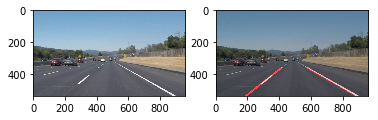

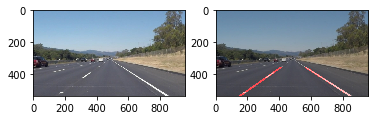

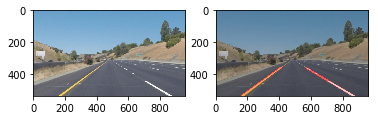

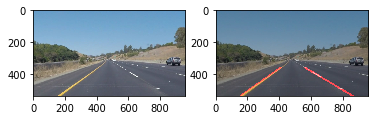

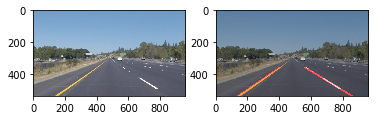

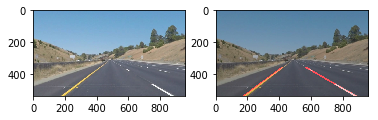

In [2]:
src_imgs = os.listdir("img_src")
for img in src_imgs:
    # read image from file
    rgb_img_src = mpimg.imread(os.path.join("img_src", img))
    
    # detect lane lines
    rgb_img_dst = detect_lane_lines(rgb_img_src)
    
    # save resulting image to image destination folder
    plt.imsave(os.path.join("img_dst", img), rgb_img_dst)
    
    # display source image on the left side and 
    # resuling image on the right side
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(rgb_img_src)

    fig.add_subplot(1, 2, 2)
    plt.imshow(rgb_img_dst)
    plt.show()

## Results on Several Videos
Initial videos are located in [`vid_src`](./vid_src) folder and the resulting images are located in [`vid_dst`](./vid_dst) folder. Only resulting videos with lane lines detected are shown below.

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import display

line_left  = list()
line_right = list()

def process_image(image):
    result = detect_lane_lines(image, line_l = line_left, line_r = line_right)

    return result

src_vids = os.listdir("vid_src")
for vid in src_vids:
    vid_dst = os.path.join("vid_dst", vid)
    video = VideoFileClip(os.path.join("vid_src", vid))
    video_clip = video.fl_image(process_image) #NOTE: this function expects color images!!!
    %time video_clip.write_videofile(vid_dst, audio = False)
    display(HTML(
        """
            <video width="960" height="540" controls>
               <source src="{0}">
            </video>
        """.format(vid_dst)))

[MoviePy] >>>> Building video vid_dst/solidWhiteRight.mp4
[MoviePy] Writing video vid_dst/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 31.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vid_dst/solidWhiteRight.mp4 

CPU times: user 6.05 s, sys: 247 ms, total: 6.3 s
Wall time: 8.01 s


[MoviePy] >>>> Building video vid_dst/solidYellowLeft.mp4
[MoviePy] Writing video vid_dst/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:21<00:00, 30.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vid_dst/solidYellowLeft.mp4 

CPU times: user 17.9 s, sys: 525 ms, total: 18.4 s
Wall time: 22 s


[MoviePy] >>>> Building video vid_dst/challenge.mp4
[MoviePy] Writing video vid_dst/challenge.mp4


100%|██████████| 251/251 [00:15<00:00, 17.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vid_dst/challenge.mp4 

CPU times: user 9.53 s, sys: 320 ms, total: 9.85 s
Wall time: 17.3 s


## Writeup Report
You can find whiteup report describing pros and cons of this implementation of lane lines detection in [Report.md](./Report.md).